#  序列到序列学习（seq2seq）



In [1]:
import sys
sys.path.append('..')

In [2]:
import collections
import math
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops
from d2l import mindspore as d2l

实现循环神经网络编码器

In [3]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0., **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
        
    def construct(self, X, X_len=None):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state

上述编码器的实现

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.set_train(False)
X = d2l.zeros((4, 7), dtype=mindspore.int32)
output, state = encoder(X)
output.shape

(7, 4, 16)

In [5]:
state.shape

(2, 4, 16)

解码器

In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0., **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Dense(num_hiddens, vocab_size) # weight_init='xavier_uniform'

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def construct(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = ops.repeat_elements(state[-1:], rep=X.shape[0], axis=0)
        X_and_context = d2l.concat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

实例化解码器

In [7]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.set_train(False)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

((4, 7, 10), (2, 4, 16))

通过零值化屏蔽不相关的项

In [8]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.shape[1]
    mask = ops.arange((maxlen), dtype=mindspore.float32)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = mindspore.Tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, mindspore.Tensor([1, 2]))

Tensor(shape=[2, 3], dtype=Int64, value=
[[1, 0, 0],
 [4, 5, 0]])

我们还可以使用此函数屏蔽最后几个轴上的所有项

In [9]:
X = d2l.ones((2, 3, 4))
sequence_mask(X, mindspore.Tensor([1, 2]), value=-1)

[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:19:51.661.294 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given dtype id is 43


Tensor(shape=[2, 3, 4], dtype=Float32, value=
[[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
  [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
  [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]],
 [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
  [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
  [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]]])

通过扩展softmax交叉熵损失函数来遮蔽不相关的预测

In [10]:
class MaskedSoftmaxCELoss(nn.Cell):
    """带遮蔽的softmax交叉熵损失函数"""
    def __init__(self):
        super().__init__()
        self.softmax_ce_loss = nn.CrossEntropyLoss()
    
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def construct(self, pred, label, valid_len):
        weights = ops.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        unweighted_loss = self.softmax_ce_loss(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(axis=1)
        return weighted_loss

代码健全性检查

In [11]:
loss = MaskedSoftmaxCELoss()
loss(ops.ones((3, 4, 10)), ops.ones((3, 4), dtype=mindspore.int32),
     mindspore.Tensor([4, 2, 0]))

[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:19:51.698.753 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given dtype id is 34


Tensor(shape=[3], dtype=Float32, value= [ 2.30258799e+00,  1.15129399e+00,  0.00000000e+00])

训练

In [12]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab):
    """训练序列到序列模型"""

    optimizer = nn.Adam(net.trainable_params(), lr)
    loss = MaskedSoftmaxCELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    def forward_fn(X, dec_input, X_valid_len, Y, Y_valid_len):
        pred, _ = net(X, dec_input, X_valid_len)
        l = loss(pred, Y, Y_valid_len)
        return l
    grad_fn = mindspore.value_and_grad(forward_fn, None, net.trainable_params(), has_aux=False)
    
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        net.set_train()
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.astype(d2l.int32) for x in batch]
            # print(X.shape, X_valid_len, Y.shape, Y_valid_len)
            bos = mindspore.Tensor([tgt_vocab['<bos>']] * Y.shape[0], dtype=mindspore.int32).reshape(-1, 1)
            dec_input = ops.concat([bos, Y[:, :-1]], 1)  # 强制教学
            l, grads = grad_fn(X, dec_input, X_valid_len, Y, Y_valid_len)
            optimizer(grads)
            num_tokens = Y_valid_len.sum()
            metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec')

创建和训练一个循环神经网络“编码器－解码器”模型

正在从http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip下载../data/fra-eng.zip...


[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:25:08.295.649 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given dtype id is 34
[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:25:09.069.676 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given dtype id is 34
[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:25:09.257.903 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given dtype id is 34
[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:25:09.440.888 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given dtype id is 34
[WARNING] CORE(25029,7f0882714080,python):2023-02-19-10:25:09.647.505 [mindspore/core/ops/fill.cc:202] FillInferValue] value type is not same as given dtype, value type id is 35 and given 

RuntimeError: Launch kernel failed, name:Default/UnsortedSegmentSum-op2003

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore/ccsrc/runtime/pynative/run_op_helper.cc:569 LaunchKernelsDynamic


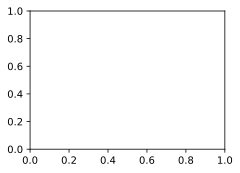

In [13]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab)

预测

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.set_train(False)
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = mindspore.Tensor([len(src_tokens)])
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = ops.unsqueeze(mindspore.Tensor(src_tokens, mindspore.int32), 0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = ops.unsqueeze(mindspore.Tensor([tgt_vocab['<bos>']], mindspore.int32), 0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(axis=2)
        pred = int(dec_X.squeeze(0).asnumpy())
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

BLEU的代码实现

In [ ]:
def bleu(pred_seq, label_seq, k):  
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

将几个英语句子翻译成法语

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')